<IPython.core.display.Javascript object>


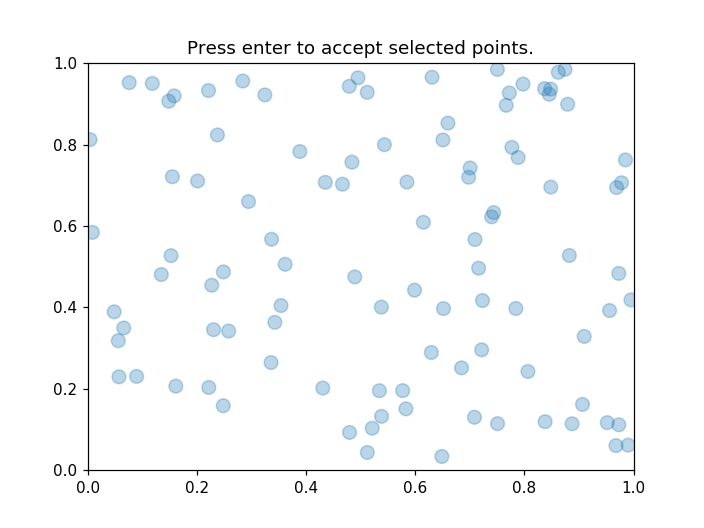

In [1]:
import numpy as np

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
%matplotlib notebook


class SelectFromCollection(object):
    """Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : :class:`~matplotlib.axes.Axes`
        Axes to interact with.

    collection : :class:`matplotlib.collections.Collection` subclass
        Collection you want to select from.

    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to `alpha_other`.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()


if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # Fixing random state for reproducibility
    np.random.seed(19680801)

    data = np.random.rand(100, 2)

    subplot_kw = dict(xlim=(0, 1), ylim=(0, 1), autoscale_on=False)
    fig, ax = plt.subplots(subplot_kw=subplot_kw)

    pts = ax.scatter(data[:, 0], data[:, 1], s=80)
    selector = SelectFromCollection(ax, pts)

    def accept(event):
        if event.key == "enter":
            print("Selected points:")
            print(selector.xys[selector.ind])
            selector.disconnect()
            ax.set_title("")
            fig.canvas.draw()

    fig.canvas.mpl_connect("key_press_event", accept)
    ax.set_title("Press enter to accept selected points.")

    plt.show()

<IPython.core.display.Javascript object>


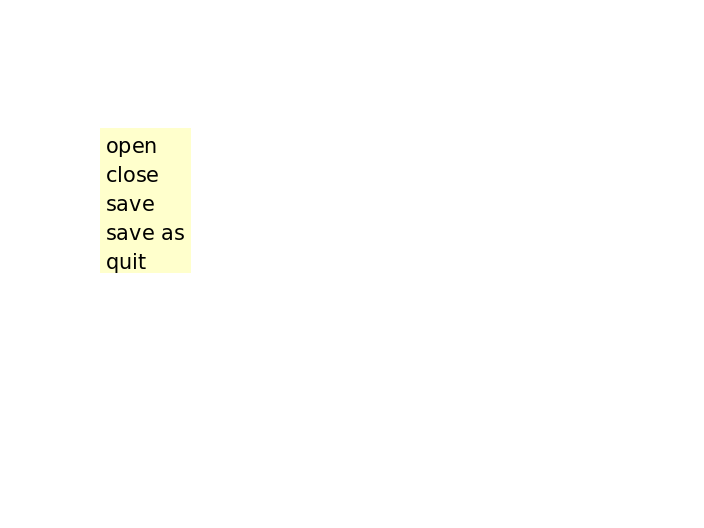

100 371 91 29
100 342 91 29
100 313 91 29
100 284 91 29
100 255 91 29


In [3]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.mathtext as mathtext
import matplotlib.pyplot as plt
import matplotlib.artist as artist
import matplotlib.image as image


class ItemProperties(object):
    def __init__(self, fontsize=14, labelcolor='black', bgcolor='yellow',
                 alpha=1.0):
        self.fontsize = fontsize
        self.labelcolor = labelcolor
        self.bgcolor = bgcolor
        self.alpha = alpha

        self.labelcolor_rgb = colors.to_rgba(labelcolor)[:3]
        self.bgcolor_rgb = colors.to_rgba(bgcolor)[:3]


class MenuItem(artist.Artist):
    parser = mathtext.MathTextParser("Bitmap")
    padx = 5
    pady = 5

    def __init__(self, fig, labelstr, props=None, hoverprops=None,
                 on_select=None):
        artist.Artist.__init__(self)

        self.set_figure(fig)
        self.labelstr = labelstr

        if props is None:
            props = ItemProperties()

        if hoverprops is None:
            hoverprops = ItemProperties()

        self.props = props
        self.hoverprops = hoverprops

        self.on_select = on_select

        x, self.depth = self.parser.to_mask(
            labelstr, fontsize=props.fontsize, dpi=fig.dpi)

        if props.fontsize != hoverprops.fontsize:
            raise NotImplementedError(
                'support for different font sizes not implemented')

        self.labelwidth = x.shape[1]
        self.labelheight = x.shape[0]

        self.labelArray = np.zeros((x.shape[0], x.shape[1], 4))
        self.labelArray[:, :, -1] = x/255.

        self.label = image.FigureImage(fig, origin='upper')
        self.label.set_array(self.labelArray)

        # we'll update these later
        self.rect = patches.Rectangle((0, 0), 1, 1)

        self.set_hover_props(False)

        fig.canvas.mpl_connect('button_release_event', self.check_select)

    def check_select(self, event):
        over, junk = self.rect.contains(event)
        if not over:
            return

        if self.on_select is not None:
            self.on_select(self)

    def set_extent(self, x, y, w, h):
        print(x, y, w, h)
        self.rect.set_x(x)
        self.rect.set_y(y)
        self.rect.set_width(w)
        self.rect.set_height(h)

        self.label.ox = x + self.padx
        self.label.oy = y - self.depth + self.pady/2.

        self.hover = False

    def draw(self, renderer):
        self.rect.draw(renderer)
        self.label.draw(renderer)

    def set_hover_props(self, b):
        if b:
            props = self.hoverprops
        else:
            props = self.props

        r, g, b = props.labelcolor_rgb
        self.labelArray[:, :, 0] = r
        self.labelArray[:, :, 1] = g
        self.labelArray[:, :, 2] = b
        self.label.set_array(self.labelArray)
        self.rect.set(facecolor=props.bgcolor, alpha=props.alpha)

    def set_hover(self, event):
        'check the hover status of event and return true if status is changed'
        b, junk = self.rect.contains(event)

        changed = (b != self.hover)

        if changed:
            self.set_hover_props(b)

        self.hover = b
        return changed


class Menu(object):
    def __init__(self, fig, menuitems):
        self.figure = fig
        fig.suppressComposite = True

        self.menuitems = menuitems
        self.numitems = len(menuitems)

        maxw = max(item.labelwidth for item in menuitems)
        maxh = max(item.labelheight for item in menuitems)

        totalh = self.numitems*maxh + (self.numitems + 1)*2*MenuItem.pady

        x0 = 100
        y0 = 400

        width = maxw + 2*MenuItem.padx
        height = maxh + MenuItem.pady

        for item in menuitems:
            left = x0
            bottom = y0 - maxh - MenuItem.pady

            item.set_extent(left, bottom, width, height)

            fig.artists.append(item)
            y0 -= maxh + MenuItem.pady

        fig.canvas.mpl_connect('motion_notify_event', self.on_move)

    def on_move(self, event):
        draw = False
        for item in self.menuitems:
            draw = item.set_hover(event)
            if draw:
                self.figure.canvas.draw()
                break


fig = plt.figure()
fig.subplots_adjust(left=0.3)
props = ItemProperties(labelcolor='black', bgcolor='yellow',
                       fontsize=15, alpha=0.2)
hoverprops = ItemProperties(labelcolor='white', bgcolor='blue',
                            fontsize=15, alpha=0.2)

menuitems = []
for label in ('open', 'close', 'save', 'save as', 'quit'):
    def on_select(item):
        print('you selected %s' % item.labelstr)
    item = MenuItem(fig, label, props=props, hoverprops=hoverprops,
                    on_select=on_select)
    menuitems.append(item)

menu = Menu(fig, menuitems)
plt.show()